# SIECI NEURONOWE – ćwiczenie 5
W ćwiczeniu 5 wykorzystamy sieć wielowarstwową do klasyfikacji obrazów.

Skorzystamy ze zbioru FashionMNIST, który jest domyślnie dostępny w torchvision:

    data = torchvision.datasets.FashionMNIST('path', download = True)

    data_loader = torch.utils.data.DataLoader(data,

    batch_size=16,

    shuffle=True)

DataLoader jest iteratorem zwracającym batchowane pary wejść-wyjść, wyjściem jest w tym przypadku jedna z dziesięciu klas oznaczających rodzaje ubrań, które widzimy na obrazie.

Ze względu na fakt że dane są obrazkami, będzie trzeba przekształcić je do macierzy cech którą jest w stanie przyjąć warstwa liniowa, spłaszczając tensor (metody operujące na kształcie tensora dostępne w torch.tensor, istnieje również warstwa Flatten).

Należy dla jedno i dwuwarstwowej sieci neuronowej porównać wyniki i krzywe uczenia w zależności od:
- Liczby neuronów w warstwie ukrytej
- Rozmiaru batcha
- Liczby przykładów uczących (należy wykorzystać podzbiory zbioru uczącego o różnych rozmiarach zamiast pełnego zbioru uczącego – sprawdzić rozmiary 1% danych, 10% danych)
- Zaburzenia danych: dane można zaburzyć dodając do wejściowego batcha batch o tych samych wymiarach, wygenerowany jako szum gaussowski o różnych odchyleniach. Przebadać scenariusze: szum dodany w danych testowych vs szum dodany zarówno w testowych, jak i treningowych.

Ćwiczenie oceniane jest w skali 0-10 pkt.

## Przygotowanie i deklaracje klas

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_1 = create_subset(train_data, 0.01)
train_10 = create_subset(train_data, 0.10)
train_100 = train_data

test_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

def create_subset(dataset, percentage):
    size = int(len(dataset) * percentage)
    indices = np.random.choice(len(dataset), size=size, replace=False)
    return Subset(dataset, indices)

def add_gaussian_noise(images, std):
    noise = torch.randn_like(images) * std
    return images + noise

class SingleLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

class TwoLayerNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


## Trening

In [19]:
def train_model(model, train_loader, test_loader, epochs=5, noise_std_train=0.0, noise_std_test=0.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list, test_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            if noise_std_train > 0:
                images = add_gaussian_noise(images, noise_std_train)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_acc_list.append(train_acc)

        # --- TESTOWANIE ---
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                if noise_std_test > 0:
                    images = add_gaussian_noise(images, noise_std_test)

                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}, Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

    return train_acc_list, test_acc_list

## Eksperymenty


=== Hidden size 32 ===
Epoch 1, Train Acc=0.786, Test Acc=0.819
Epoch 2, Train Acc=0.838, Test Acc=0.834
Epoch 3, Train Acc=0.847, Test Acc=0.837
Epoch 4, Train Acc=0.852, Test Acc=0.838
Epoch 5, Train Acc=0.856, Test Acc=0.838
Epoch 1, Train Acc=0.797, Test Acc=0.828
Epoch 2, Train Acc=0.844, Test Acc=0.838
Epoch 3, Train Acc=0.855, Test Acc=0.836
Epoch 4, Train Acc=0.861, Test Acc=0.850
Epoch 5, Train Acc=0.869, Test Acc=0.851

=== Hidden size 64 ===
Epoch 1, Train Acc=0.785, Test Acc=0.821
Epoch 2, Train Acc=0.838, Test Acc=0.833
Epoch 3, Train Acc=0.848, Test Acc=0.836
Epoch 4, Train Acc=0.853, Test Acc=0.840
Epoch 5, Train Acc=0.856, Test Acc=0.838
Epoch 1, Train Acc=0.804, Test Acc=0.833
Epoch 2, Train Acc=0.853, Test Acc=0.833
Epoch 3, Train Acc=0.864, Test Acc=0.860
Epoch 4, Train Acc=0.870, Test Acc=0.849
Epoch 5, Train Acc=0.877, Test Acc=0.859

=== Hidden size 128 ===
Epoch 1, Train Acc=0.790, Test Acc=0.818
Epoch 2, Train Acc=0.838, Test Acc=0.831
Epoch 3, Train Acc=0.848,

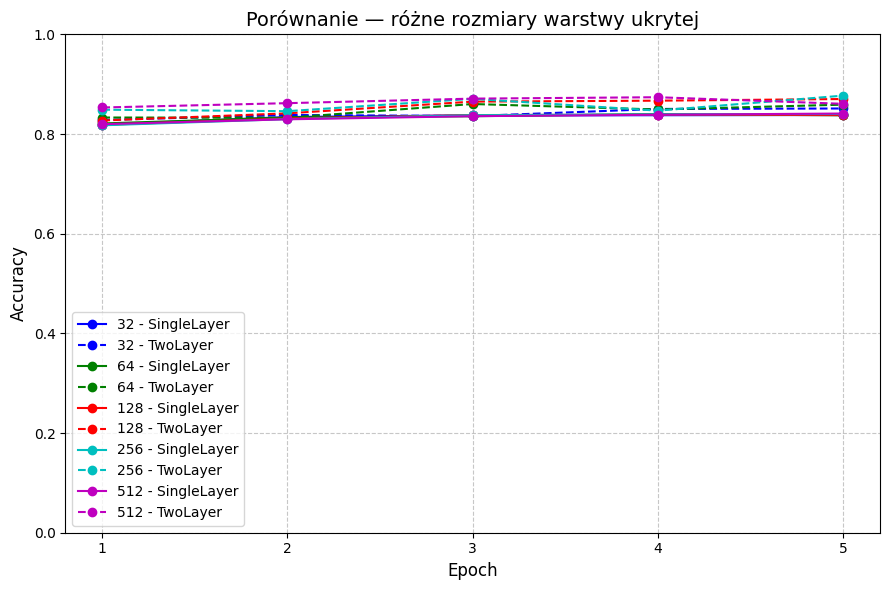


=== Batch size 16 ===
Epoch 1, Train Acc=0.811, Test Acc=0.827
Epoch 2, Train Acc=0.846, Test Acc=0.839
Epoch 3, Train Acc=0.853, Test Acc=0.844
Epoch 4, Train Acc=0.854, Test Acc=0.835
Epoch 5, Train Acc=0.857, Test Acc=0.842
Epoch 1, Train Acc=0.823, Test Acc=0.839
Epoch 2, Train Acc=0.864, Test Acc=0.864
Epoch 3, Train Acc=0.877, Test Acc=0.862
Epoch 4, Train Acc=0.885, Test Acc=0.873
Epoch 5, Train Acc=0.891, Test Acc=0.873

=== Batch size 32 ===
Epoch 1, Train Acc=0.801, Test Acc=0.828
Epoch 2, Train Acc=0.843, Test Acc=0.833
Epoch 3, Train Acc=0.850, Test Acc=0.835
Epoch 4, Train Acc=0.855, Test Acc=0.841
Epoch 5, Train Acc=0.858, Test Acc=0.843
Epoch 1, Train Acc=0.820, Test Acc=0.848
Epoch 2, Train Acc=0.864, Test Acc=0.841
Epoch 3, Train Acc=0.876, Test Acc=0.868
Epoch 4, Train Acc=0.884, Test Acc=0.867
Epoch 5, Train Acc=0.890, Test Acc=0.872

=== Batch size 64 ===
Epoch 1, Train Acc=0.785, Test Acc=0.820
Epoch 2, Train Acc=0.838, Test Acc=0.834
Epoch 3, Train Acc=0.847, Tes

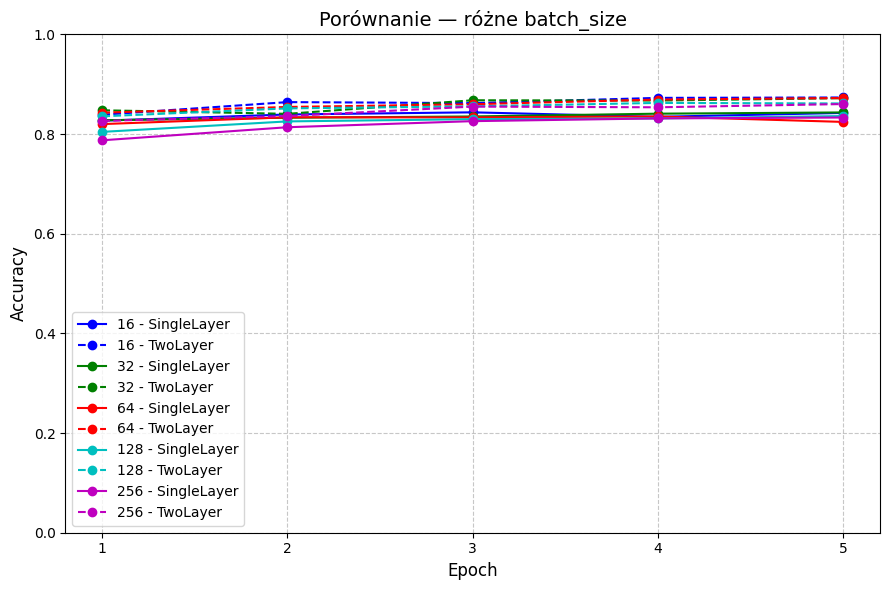


=== Training size 1% ===
Epoch 1, Train Acc=0.232, Test Acc=0.486
Epoch 2, Train Acc=0.518, Test Acc=0.623
Epoch 3, Train Acc=0.635, Test Acc=0.635
Epoch 4, Train Acc=0.662, Test Acc=0.655
Epoch 5, Train Acc=0.675, Test Acc=0.666
Epoch 1, Train Acc=0.335, Test Acc=0.574
Epoch 2, Train Acc=0.643, Test Acc=0.637
Epoch 3, Train Acc=0.648, Test Acc=0.653
Epoch 4, Train Acc=0.692, Test Acc=0.682
Epoch 5, Train Acc=0.712, Test Acc=0.684

=== Training size 10% ===
Epoch 1, Train Acc=0.636, Test Acc=0.706
Epoch 2, Train Acc=0.751, Test Acc=0.754
Epoch 3, Train Acc=0.783, Test Acc=0.774
Epoch 4, Train Acc=0.798, Test Acc=0.783
Epoch 5, Train Acc=0.809, Test Acc=0.795
Epoch 1, Train Acc=0.675, Test Acc=0.723
Epoch 2, Train Acc=0.779, Test Acc=0.784
Epoch 3, Train Acc=0.819, Test Acc=0.796
Epoch 4, Train Acc=0.831, Test Acc=0.812
Epoch 5, Train Acc=0.842, Test Acc=0.821

=== Training size 100% ===
Epoch 1, Train Acc=0.788, Test Acc=0.821
Epoch 2, Train Acc=0.838, Test Acc=0.829
Epoch 3, Train Ac

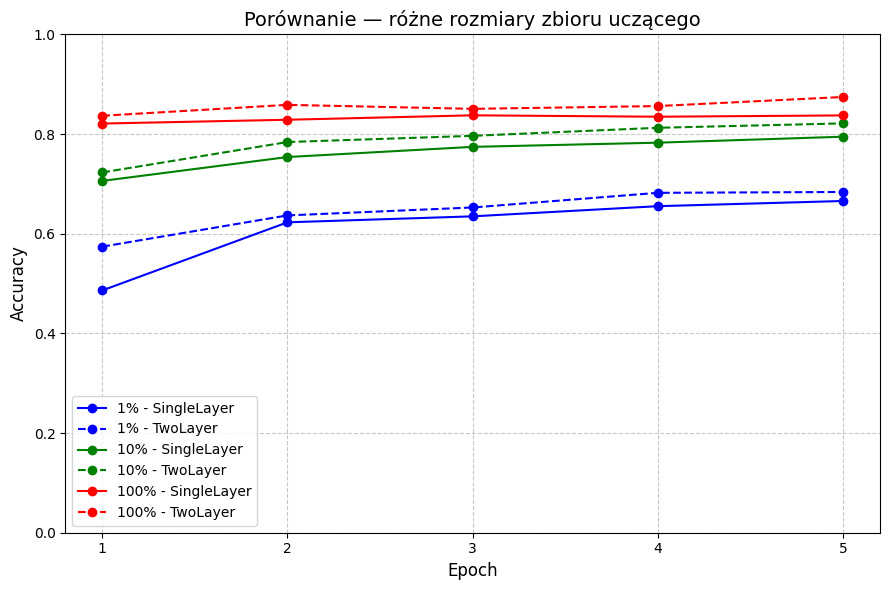


=== Szum 0.1 — tylko test ===
Epoch 1, Train Acc=0.784, Test Acc=0.816
Epoch 2, Train Acc=0.838, Test Acc=0.829
Epoch 3, Train Acc=0.847, Test Acc=0.830
Epoch 4, Train Acc=0.853, Test Acc=0.831
Epoch 5, Train Acc=0.856, Test Acc=0.834
Epoch 1, Train Acc=0.810, Test Acc=0.817
Epoch 2, Train Acc=0.857, Test Acc=0.847
Epoch 3, Train Acc=0.870, Test Acc=0.856
Epoch 4, Train Acc=0.881, Test Acc=0.859
Epoch 5, Train Acc=0.886, Test Acc=0.863

=== Szum 0.1 — train + test ===
Epoch 1, Train Acc=0.785, Test Acc=0.816
Epoch 2, Train Acc=0.832, Test Acc=0.827
Epoch 3, Train Acc=0.840, Test Acc=0.831
Epoch 4, Train Acc=0.845, Test Acc=0.833
Epoch 5, Train Acc=0.847, Test Acc=0.831
Epoch 1, Train Acc=0.806, Test Acc=0.837
Epoch 2, Train Acc=0.852, Test Acc=0.849
Epoch 3, Train Acc=0.864, Test Acc=0.858
Epoch 4, Train Acc=0.872, Test Acc=0.861
Epoch 5, Train Acc=0.877, Test Acc=0.857

=== Szum 0.1 — tylko train ===
Epoch 1, Train Acc=0.780, Test Acc=0.818
Epoch 2, Train Acc=0.830, Test Acc=0.826
Ep

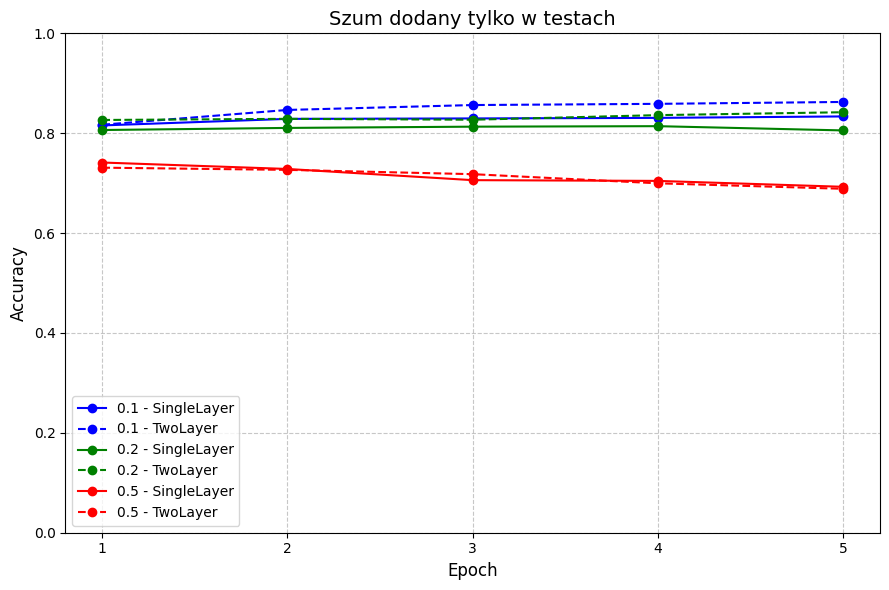

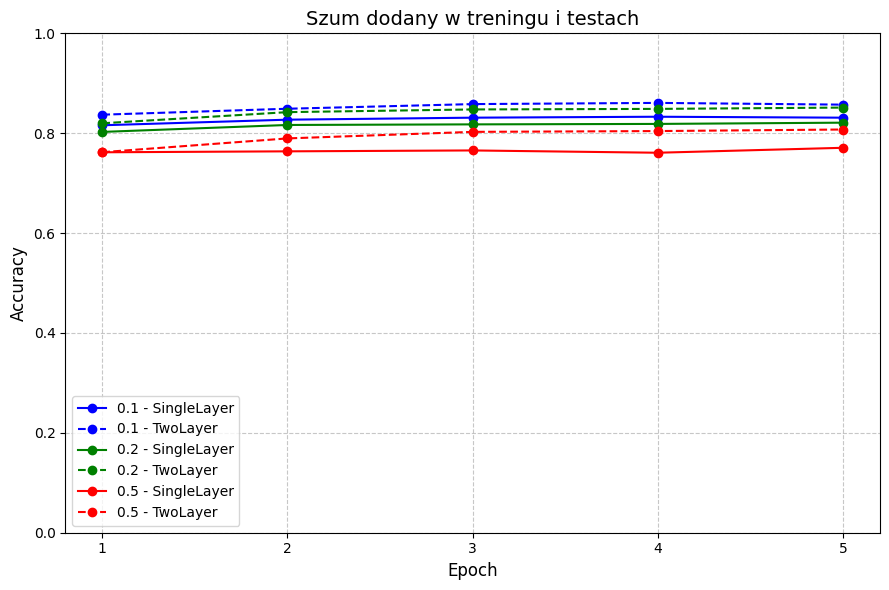

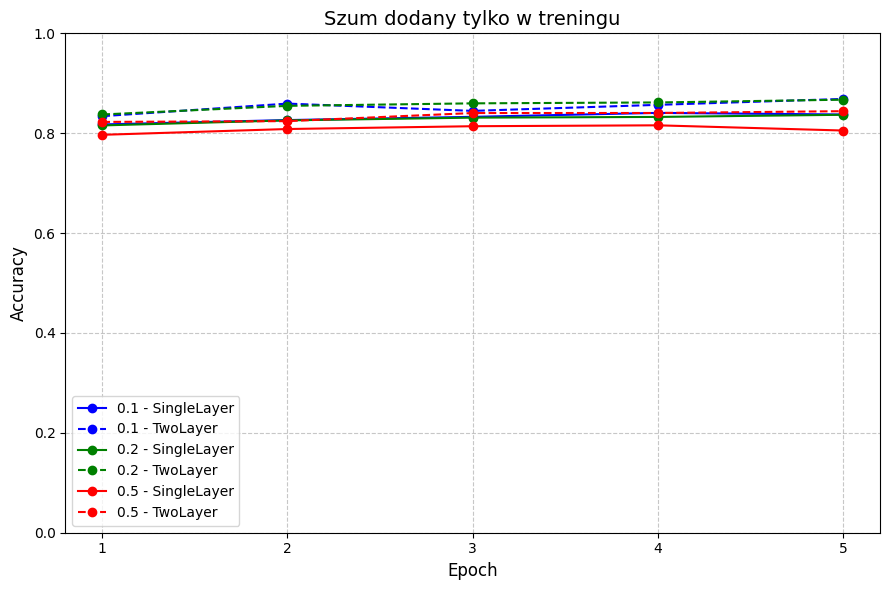

In [20]:
def plot_results_comparison(results_dict, title):
    plt.figure(figsize=(9,6))
    styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (key, models) in enumerate(results_dict.items()):
        for j, (model_name, (train_acc, test_acc)) in enumerate(models.items()):
            plt.plot(range(1, len(test_acc)+1), test_acc, 
                     linestyle=styles[j % len(styles)],
                     color=colors[i % len(colors)],
                     marker='o',
                     label=f"{key} - {model_name}")

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0,1)
    plt.xticks(range(1, len(test_acc)+1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# --- Eksperyment 1: różne rozmiary warstwy ukrytej ---
hidden_sizes = [32, 64, 128, 256, 512]
results_hidden = {}

for h in hidden_sizes:
    print(f"\n=== Hidden size {h} ===")
    
    model_single = SingleLayerNN()
    train_loader = DataLoader(train_100, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64)
    train_acc_s, test_acc_s = train_model(model_single, train_loader, test_loader)
    
    model_two = TwoLayerNN(hidden_size=h)
    train_acc_t, test_acc_t = train_model(model_two, train_loader, test_loader)
    
    results_hidden[h] = {
        "SingleLayer": (train_acc_s, test_acc_s),
        "TwoLayer": (train_acc_t, test_acc_t)
    }

plot_results_comparison(results_hidden, "Porównanie — różne rozmiary warstwy ukrytej")

# --- Eksperyment 2: różne batch_size ---
batch_sizes = [16, 32, 64, 128, 256]
results_batch = {}

for bs in batch_sizes:
    print(f"\n=== Batch size {bs} ===")
    
    model_single = SingleLayerNN()
    train_loader = DataLoader(train_100, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=bs)
    train_acc_s, test_acc_s = train_model(model_single, train_loader, test_loader)
    
    model_two = TwoLayerNN(hidden_size=128)
    train_acc_t, test_acc_t = train_model(model_two, train_loader, test_loader)
    
    results_batch[bs] = {
        "SingleLayer": (train_acc_s, test_acc_s),
        "TwoLayer": (train_acc_t, test_acc_t)
    }

plot_results_comparison(results_batch, "Porównanie — różne batch_size")

# --- Eksperyment 3: różne rozmiary zbioru treningowego ---
datasets = [("1%", train_1), ("10%", train_10), ("100%", train_100)]
results_data = {}

for name, ds in datasets:
    print(f"\n=== Training size {name} ===")
    
    train_loader = DataLoader(ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64)
    
    model_single = SingleLayerNN()
    train_acc_s, test_acc_s = train_model(model_single, train_loader, test_loader)
    
    model_two = TwoLayerNN(hidden_size=128)
    train_acc_t, test_acc_t = train_model(model_two, train_loader, test_loader)
    
    results_data[name] = {
        "SingleLayer": (train_acc_s, test_acc_s),
        "TwoLayer": (train_acc_t, test_acc_t)
    }

plot_results_comparison(results_data, "Porównanie — różne rozmiary zbioru uczącego")

# --- Eksperyment 4 i 5: szum w danych ---
std_values = [0.1, 0.2, 0.5]

results_noise_test = {}
results_noise_both = {}
results_noise_train = {}

for std in std_values:
    print(f"\n=== Szum {std} — tylko test ===")
    train_loader = DataLoader(train_100, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64)
    
    model_single = SingleLayerNN()
    train_acc_s, test_acc_s = train_model(model_single, train_loader, test_loader, noise_std_train=0.0, noise_std_test=std)
    model_two = TwoLayerNN(hidden_size=128)
    train_acc_t, test_acc_t = train_model(model_two, train_loader, test_loader, noise_std_train=0.0, noise_std_test=std)
    results_noise_test[std] = {"SingleLayer": (train_acc_s, test_acc_s), "TwoLayer": (train_acc_t, test_acc_t)}
    
    print(f"\n=== Szum {std} — train + test ===")
    model_single = SingleLayerNN()
    train_acc_s, test_acc_s = train_model(model_single, train_loader, test_loader, noise_std_train=std, noise_std_test=std)
    model_two = TwoLayerNN(hidden_size=128)
    train_acc_t, test_acc_t = train_model(model_two, train_loader, test_loader, noise_std_train=std, noise_std_test=std)
    results_noise_both[std] = {"SingleLayer": (train_acc_s, test_acc_s), "TwoLayer": (train_acc_t, test_acc_t)}
    
    print(f"\n=== Szum {std} — tylko train ===")
    model_single = SingleLayerNN()
    train_acc_s, test_acc_s = train_model(model_single, train_loader, test_loader, noise_std_train=std, noise_std_test=0.0)
    model_two = TwoLayerNN(hidden_size=128)
    train_acc_t, test_acc_t = train_model(model_two, train_loader, test_loader, noise_std_train=std, noise_std_test=0.0)
    results_noise_train[std] = {"SingleLayer": (train_acc_s, test_acc_s), "TwoLayer": (train_acc_t, test_acc_t)}

plot_results_comparison(results_noise_test, "Szum dodany tylko w testach")
plot_results_comparison(results_noise_both, "Szum dodany w treningu i testach")
plot_results_comparison(results_noise_train, "Szum dodany tylko w treningu")